In [5]:
import numpy as np
import pandas as pd
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Expected Standard Error

In [6]:
# historical data
pv = 40000
n_click = 3200
n_enrol = 660
p_pay_enrol = 0.53
test_size = 5000


# calculation
p_enrol_click = n_enrol/n_click
p_pay_click = p_pay_enrol * p_enrol_click # assume the two events are independent

sd_retention = math.sqrt((p_pay_enrol * (1 - p_pay_enrol)) / (test_size * (n_enrol / pv)))
sd_net_conversion = math.sqrt((p_pay_click * (1 - p_pay_click)) / (test_size * (n_click / pv)))
sd_retention
sd_net_conversion

0.05494901217850908

0.015601544582488459

## Test Size

### Stats Formula & Packages
The formulas are specifically for 2 sample tests of proportion  
1. Wang, H. and Chow, S.-C. 2007. Sample Size Calculation for Comparing Proportions. Wiley Encyclopedia of Clinical Trials.http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.571.2708&rep=rep1&type=pdf
$$n = \frac{(Z_{\alpha/2} + Z_\beta)^2(p_1(1-p_1)+p_2(1-p_2))}{(p_1-p_2)^2}$$

2. R and G\*Power Formula https://jeffshow.com/caculate-abtest-required-sample-size.html, also in Applied Statistics and Probability for Engineers, 3rd. Douglas C. Montgomery, George C. Runger, p. 364
$$n = \frac{[{Z_{\alpha/2}\sqrt{2\frac{(p_1+p_2)}{2}(1-\frac{(p_1+p_2)}{2})}+Z_\beta\sqrt{p_1(1-p_1)+p_2(1-p_2)}}]^2}{(p_1-p_2)^2}$$

The two above give almost identical results

3. statsmodels.stats.proportion  
Gives small numbers, see plot below.

**Finite population correction**  
https://select-statistics.co.uk/calculators/sample-size-calculator-two-proportions/
"Most sample size calculations assume that the population is large (or even infinite). With a finite, small population, the variability of the sample is actually less than expected, and therefore a “finite population correction”, FPC, can be applied to account for this greater efficiency in the sampling process.

For a large population (greater than 100,000 or so), there’s not normally any correction needed to the standard sample size formulae available. For large, finite populations, the FPC will have little effect and the sample size will be similar to that for an infinite population. 

However, the effect of the FPC will be noticeable if one or both of the population sizes (N’s) is small relative to n in the formula above."

The correction result is :
$$n = \frac{X*A}{1+X*B}$$
where $X = \frac{{Z_{\alpha/2}+Z_\beta}^2}{{p_1-p_2}^2}$, $A = \frac{N_1}{N_1-1}(p_1*(1-p_1))+\frac{N_2}{N_2-1}(p_2*(1-p_2))$,
$B=\frac{1}{N_1-1}(p_1*(1-p_1))+\frac{1}{N_2-1}(p_2*(1-p_2))$

In [137]:
def get_size(alpha, beta, baseline, min_effect):
    '''
    alpha: significance level
    beta: statistical power = 1 - beta
    baseline: baseline conversion rate, in [0,1]
    min_effect: minimum detectable effect, in [0,1]
    return: 4 methods of sample size calculation
    '''
    import scipy.stats as st
    z_alpha = st.norm.ppf(1 - alpha / 2)
    z_beta = st.norm.ppf(1 - beta)
    p1 = baseline
    p2 = baseline + min_effect
    
    from statsmodels.stats.power import zt_ind_solve_power
    from statsmodels.stats.proportion import proportion_effectsize as es
         
    size = ((z_alpha + z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))) / (p1 - p2) ** 2
    size2 = (z_alpha * math.sqrt((p1 + p2) * (1 - p1 + 1 - p2) * 0.5) + z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2 / (p1 - p2) ** 2 
    size3 = zt_ind_solve_power(effect_size=es(prop1=p1, prop2=p2), alpha=alpha, power=beta, alternative="two-sided")
    
    return size,  size2, size3

In [139]:
nums = np.linspace(0.01,0.95,100)
size_1, size_2, size_3= [],[],[]
for i in nums:
    num1, num2, num3 = get_size(alpha = 0.05, beta = 0.2, baseline = i, min_effect = 0.01 if (i>0.001 and i+0.01 < 1) else 0)
    size_1.append(num1)
    size_2.append(num2)
    size_3.append(num3)

lines = pd.DataFrame({
    'probability':nums,
    'size_1':size_1,
    'size_2':size_2,
    'size_3':size_3
})

,probability,size_1,size_2,size_3
0,0.010000,2315.419522,2318.164676,356.694709
1,0.019495,3747.046857,3749.792144,587.528984
2,0.028990,5150.369855,5153.115201,811.448761
3,0.038485,6525.388516,6528.133895,1030.086449
4,0.047980,7872.102841,7874.848241,1243.879111
...,...,...,...,...
95,0.912020,11941.152371,11943.897806,1888.960639
96,0.921515,10683.867706,10686.613134,1689.725061
97,0.931010,9398.278705,9401.024122,1485.937370
98,0.940505,8084.385367,8087.130770,1277.559547


<AxesSubplot:xlabel='probability', ylabel='value'>

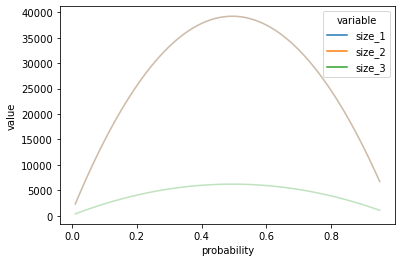

In [142]:
import seaborn as sns
lines
sns.lineplot(x='probability', y='value', hue='variable', 
             data=pd.melt(lines, ['probability']), alpha = 0.3)

In [94]:
base_retention = p_enrol_click
base_conversion = p_pay_enrol
retention = get_size(alpha=0.05, beta=0.2, baseline=base_retention, min_effect=0.01)
conversion = get_size(alpha=0.05, beta=0.2, baseline=base_conversion, min_effect=0.01)
inv_p_click =  pv/ n_click
inv_p_enrol =  pv / n_enrol
re_lst = [float(x) * 2 * inv_p_click for x in retention]
conv_lst = [float(x) * 2 * inv_p_enrol for x in conversion]
math.ceil(max(max(re_lst), max(conv_lst)))

4733446

### Using standard error to calculate
Another method is to calculate by the relationship between alpha and beta, it's possibly not restricted to 2 sample proportion test.

In [102]:
from scipy.stats import norm
# Inputs:
#   The desired alpha for a two-tailed test
# Returns: The z-critical value
def get_z_star(alpha):
    return norm.ppf((1-alpha/2))

# Inputs:
#   z-star: The z-critical value
#   s: The standard error of the metric at N=1
#   d_min: The practical significance level
#   N: The sample size of each group of the experiment
# Returns: The beta value of the two-tailed test
def get_beta(z_star,s, d_min, N):
    SE = s /  math.sqrt(N)
    return norm.cdf(z_star*SE,d_min,SE)

# Inputs:
#   s: The standard error of the metric with N=1 in each group
#   d_min: The practical significance level
#   Ns: The sample sizes to try
#   alpha: The desired alpha level of the test
#   beta: The desired beta level of the test
# Returns: The smallest N out of the given Ns that will achieve the desired
#          beta. There should be at least N samples in each group of the experiment.
#          If none of the given Ns will work, returns -1. N is the number of
#          samples in each group.
def required_size(s, d_min, Ns=200000, alpha=0.05, beta=0.2):
    z=get_z_star(alpha)
    for N in range(1,Ns):        
        if get_beta(z, s, d_min, N) <= beta:
            return N
    return -1

In [104]:
"""number of clickes needed for net_conversion"""
click_through_probability=0.08
n=1 ## Start the guessing from 1
s=math.sqrt(p_pay_click*(1-p_pay_click)/n)
d_min=0.0075
req=required_size(s,d_min)
print("number of clicks needed for net_conversion:",int(req))
print("number of pageviews needed for net_conversion:",int(req/click_through_probability))

'number of clickes needed for net_conversion'

number of clicks needed for net_conversion: 13586
number of pageviews needed for net_conversion: 169825


In [106]:
"""number of enrollment needed for retention"""
n=1
s=math.sqrt(p_pay_enrol*(1-p_pay_enrol)/n)
d_min=0.01
req=required_size(s,d_min)
print("number of clicks needed for retention:",int(req))
print("number of pageviews needed for retentionn:",int(req/(n_enrol/pv)))

'number of enrollment needed for retention'

number of clicks needed for retention: 19552
number of pageviews needed for retentionn: 1184969


In [111]:
s = math.sqrt(p_pay_enrol*(1-p_pay_enrol)/n)
N = range(1, 20000)
beta = []
z_star = 1.96
for n in N:
    SE = s /  math.sqrt(n)
    beta.append(norm.cdf(z_star*SE,d_min,SE))

<AxesSubplot:xlabel='N', ylabel='beta'>

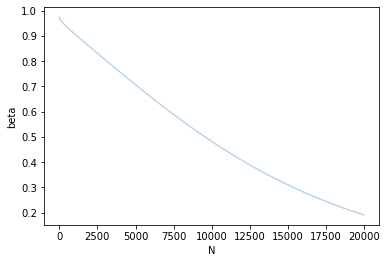

In [114]:
betas = pd.DataFrame({
    'N':N,
    'beta':beta
})

sns.lineplot(x='N', y='beta', 
             data=betas, alpha = 0.3)

## Sanity Check

In [95]:
dates=['Sat, Oct 11', 'Sun, Oct 12', 'Mon, Oct 13', 'Tue, Oct 14',
       'Wed, Oct 15', 'Thu, Oct 16', 'Fri, Oct 17', 'Sat, Oct 18',
       'Sun, Oct 19', 'Mon, Oct 20', 'Tue, Oct 21', 'Wed, Oct 22',
       'Thu, Oct 23', 'Fri, Oct 24', 'Sat, Oct 25', 'Sun, Oct 26',
       'Mon, Oct 27', 'Tue, Oct 28', 'Wed, Oct 29', 'Thu, Oct 30',
       'Fri, Oct 31', 'Sat, Nov 1', 'Sun, Nov 2', 'Mon, Nov 3',
       'Tue, Nov 4', 'Wed, Nov 5', 'Thu, Nov 6', 'Fri, Nov 7',
       'Sat, Nov 8', 'Sun, Nov 9', 'Mon, Nov 10', 'Tue, Nov 11',
       'Wed, Nov 12', 'Thu, Nov 13', 'Fri, Nov 14', 'Sat, Nov 15',
       'Sun, Nov 16']
pageviews_cont=[ 7723,  9102, 10511,  9871, 10014,  9670,  9008,  7434,  8459,
       10667, 10660,  9947,  8324,  9434,  8687,  8896,  9535,  9363,
        9327,  9345,  8890,  8460,  8836,  9437,  9420,  9570,  9921,
        9424,  9010,  9656, 10419,  9880, 10134,  9717,  9192,  8630,
        8970]
pageviews_exp=[ 7716,  9288, 10480,  9867,  9793,  9500,  9088,  7664,  8434,
       10496, 10551,  9737,  8176,  9402,  8669,  8881,  9655,  9396,
        9262,  9308,  8715,  8448,  8836,  9359,  9427,  9633,  9842,
        9272,  8969,  9697, 10445,  9931, 10042,  9721,  9304,  8668,
        8988]
clicks_cont=[687, 779, 909, 836, 837, 823, 748, 632, 691, 861, 867, 838, 665,
       673, 691, 708, 759, 736, 739, 734, 706, 681, 693, 788, 781, 805,
       830, 781, 756, 825, 874, 830, 801, 814, 735, 743, 722]
clicks_exp=[686, 785, 884, 827, 832, 788, 780, 652, 697, 860, 864, 801, 642,
       697, 669, 693, 771, 736, 727, 728, 722, 695, 724, 789, 743, 808,
       831, 767, 760, 850, 851, 831, 802, 829, 770, 724, 710]
enrolls_cont=[134, 147, 167, 156, 163, 138, 146, 110, 131, 165, 196, 162, 127,
       220, 176, 161, 233, 154, 196, 167, 174, 156, 206]
enrolls_exp=[105, 116, 145, 138, 140, 129, 127,  94, 120, 153, 143, 128, 122,
       194, 127, 153, 213, 162, 201, 207, 182, 142, 182]
payment_cont=[ 70,  70,  95, 105,  64,  82,  76,  70,  60,  97, 105,  92,  56,
       122, 128, 104, 124,  91,  86,  75, 101,  93,  67]
payment_exp=[ 34,  91,  79,  92,  94,  61,  44,  62,  77,  98,  71,  70,  68,
        94,  81, 101, 119, 120,  96,  67, 123, 100, 103]

In [99]:
def get_CI_mean(alpha, control_cnt, expr_cnt, p):
    '''
    alpha: significance level
    control_cnt: control group size
    expr_cnt: experiment group size
    p: point estimate
    '''
    sd = math.sqrt(0.5 * 0.5 / (control_cnt + expr_cnt))    
    import scipy.stats as st
    z_alpha = st.norm.ppf(1 - alpha / 2)
    margin_error = sd * z_alpha
    return(p - margin_error, p + margin_error)

print(sum(pageviews_exp)/(sum(pageviews_cont)+sum(pageviews_exp)), get_CI_mean(0.05, sum(pageviews_cont), sum(pageviews_exp), 0.5))
print(sum(clicks_exp)/(sum(clicks_cont)+sum(clicks_exp)), get_CI_mean(0.05, sum(clicks_cont), sum(clicks_exp), 0.5))

0.4993603331193866 (0.4988204138245942, 0.5011795861754058)
0.49953265259333723 (0.4958845713471463, 0.5041154286528536)


In [122]:
def get_CI_prop(alpha, control_true, exp_true, control_sum, exp_sum, phat):

    prob_pool =  (control_true + exp_true) / (control_sum + exp_sum) 
    se = math.sqrt(prob_pool * (1 - prob_pool) * (1 / control_sum + 1 / exp_sum))
    import scipy.stats as st
    z_alpha = st.norm.ppf(1 - alpha / 2)
    
    margin_error = se * z_alpha
    return( phat - margin_error, phat + margin_error)

get_CI_prop(0.05, sum(clicks_cont), sum(clicks_exp), sum(pageviews_cont), sum(pageviews_exp), 0)

(-0.001295655390242568, 0.001295655390242568)

## Effect Size test

In [124]:
### retention: enroll --> payment
n = len(payment_exp)
sum_payment_cont=sum(payment_cont[:n])
sum_payment_exp=sum(payment_exp[:n])
sum_enroll_cont=sum(enrolls_cont[:n])
sum_enroll_exp=sum(enrolls_exp[:n])
p_hat = sum_payment_exp / sum_enroll_exp - sum_payment_cont / sum_enroll_cont
p_hat
get_CI_prop(0.05, sum_payment_cont, sum_payment_exp, sum_enroll_cont, sum_enroll_exp, p_hat)

0.031094804707142765

(0.008104858181445022, 0.05408475123284051)

In [125]:
### net conversion: clicks --> payment
n=len(enrolls_exp)
sum_clicks_cont=sum(clicks_cont[:n])
sum_clicks_exp=sum(clicks_exp[:n])
sum_payment_cont=sum(payment_cont[:n])
sum_payment_exp=sum(payment_exp[:n])
p_hat = sum_payment_exp/sum_clicks_exp-sum_payment_cont/sum_clicks_cont
p_hat
get_CI_prop(0.05, sum_payment_cont, sum_payment_exp, sum_clicks_cont, sum_clicks_exp, p_hat)

-0.0048737226745441675

(-0.011604500677993734, 0.0018570553289053993)

## Sign Test

In [135]:
from scipy.stats import wilcoxon
n = len(payment_exp)
retention_exp = [x/y for x,y in zip(payment_exp[:n], enrolls_exp[:n])]
retention_cont = [x/y for x,y in zip(payment_cont[:n], enrolls_cont[:n])]

wilcoxon(retention_exp, retention_cont)

WilcoxonResult(statistic=107.0, pvalue=0.36039113998413086)

In [136]:
n=len(enrolls_exp)
conversion_exp = [x/y for x,y in zip(payment_exp[:n], clicks_exp[:n])]
conversion_cont = [x/y for x,y in zip(payment_cont[:n], clicks_cont[:n])]

wilcoxon(conversion_exp, conversion_cont)

WilcoxonResult(statistic=120.0, pvalue=0.6010458469390869)